In [1]:
# Reference: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

import argparse
from distutils.util import strtobool
import collections
import numpy as np
import gym
from gym.wrappers import TimeLimit, Monitor
from gym.spaces import Discrete, Box, MultiBinary, MultiDiscrete, Space
import time
import random
import os

# TRY NOT TO MODIFY: seeding
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
env = gym.make('CartPole-v1')
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

# modified from https://github.com/seungeunrho/minimalRL/blob/master/dqn.py#
class ReplayBuffer():
    def __init__(self, buffer_limit):
        self.buffer = collections.deque(maxlen=buffer_limit)
    
    def put(self, transition):
        self.buffer.append(transition)
    
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []
        
        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append(a)
            r_lst.append(r)
            s_prime_lst.append(s_prime)
            done_mask_lst.append(done_mask)

        return np.array(s_lst), np.array(a_lst), \
               np.array(r_lst), np.array(s_prime_lst), \
               np.array(done_mask_lst)

# ALGO LOGIC: initialize agent here:
class QNetwork(nn.Module):
    def __init__(self, env):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(np.array(env.observation_space.shape).prod(), 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, env.action_space.n)

    def forward(self, x, device):
        x = torch.Tensor(x).to(device)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

def linear_schedule(start_e: float, end_e: float, duration: int, t: int):
    slope =  (end_e - start_e) / duration
    return max(slope * t + start_e, end_e)

buffer_size = 10_000
lr = 1e-5

rb = ReplayBuffer(buffer_size)
q_network = QNetwork(env).to(device)
target_network = QNetwork(env).to(device)
target_network.load_state_dict(q_network.state_dict())
optimizer = optim.Adam(q_network.parameters())
loss_fn = nn.MSELoss()
print(device.__repr__())
print(q_network)

# TRY NOT TO MODIFY: start the game
obs = env.reset()
episode_reward = 0
total_timesteps = 100_000
start_e = 1.0
end_e = 0.05
exploration_fraction = 0.5
exploration_steps = int(exploration_fraction * total_timesteps)
train_frequency = 10
learning_starts = buffer_size
batch_size = 64
max_grad_norm = 1.0
target_network_frequency = 100
gamma = 0.99

episode = 0
episode_rewards = []
step_rewards = []

for global_step in range(total_timesteps):

    # ALGO LOGIC: put action logic here
    epsilon = linear_schedule(start_e, end_e, exploration_fraction*total_timesteps, global_step)
    
    if random.random() < epsilon:
        action = env.action_space.sample()
    else:
        logits = q_network.forward(obs.reshape((1,)+obs.shape), device)
        action = torch.argmax(logits, dim=1).tolist()[0]

    # TRY NOT TO MODIFY: execute the game and log data.
    next_obs, reward, done, _ = env.step(action)
    episode_reward += reward
    step_rewards.append(reward)

    # ALGO LOGIC: training.
    rb.put((obs, action, reward, next_obs, done))
    if global_step > learning_starts and global_step % train_frequency == 0:
        s_obs, s_actions, s_rewards, s_next_obses, s_dones = rb.sample(batch_size)
        with torch.no_grad():
            target_max = torch.max(q_network.forward(s_next_obses, device), dim=1)[0]
            td_target = torch.Tensor(s_rewards).to(device) + gamma * target_max * (1 - torch.Tensor(s_dones).to(device))
        old_val = q_network.forward(s_obs, device).gather(1, torch.LongTensor(s_actions).view(-1,1).to(device)).squeeze()
        loss = loss_fn(td_target, old_val)

        # optimize the midel
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(list(q_network.parameters()), max_grad_norm)
        optimizer.step()

    # update the target network
    if global_step % target_network_frequency == 0:
        target_network.load_state_dict(q_network.state_dict())

    # TRY NOT TO MODIFY: CRUCIAL step easy to overlook 
    obs = next_obs

    if done:
        episode += 1
        # TRY NOT TO MODIFY: record rewards for plotting purposes
        print(f"episode={episode}, global_step={global_step}, episode_reward={episode_reward}, epsilon={epsilon}")
        episode_rewards.append(episode_reward)
        obs, episode_reward = env.reset(), 0

device(type='cuda')
QNetwork(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)
episode=1, global_step=39, episode_reward=40.0, epsilon=0.999259
episode=2, global_step=61, episode_reward=22.0, epsilon=0.998841
episode=3, global_step=88, episode_reward=27.0, epsilon=0.998328
episode=4, global_step=97, episode_reward=9.0, epsilon=0.998157
episode=5, global_step=117, episode_reward=20.0, epsilon=0.997777
episode=6, global_step=127, episode_reward=10.0, epsilon=0.997587
episode=7, global_step=163, episode_reward=36.0, epsilon=0.996903
episode=8, global_step=192, episode_reward=29.0, epsilon=0.996352
episode=9, global_step=218, episode_reward=26.0, epsilon=0.995858
episode=10, global_step=238, episode_reward=20.0, epsilon=0.995478
episode=11, global_step=247, episode_reward=9.0, epsilon=0.995307
episode=12, global_step=257, episode_reward=10.0, epsilon=0.995117
e

In [2]:
import matplotlib.pyplot as plt

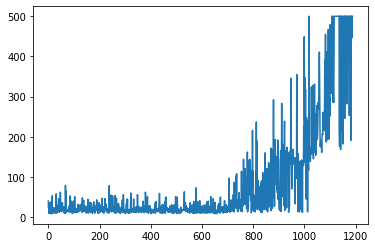

In [4]:
plt.plot(episode_rewards)